# **XI UIMP Summer School on Integrative Synthetic Biology.**
*La ingeniería de la biología como tecnología transformadora*

## Workshop. ML & AI tools for engineering biological circuits design

Outline:

* Quantitative data-driven: Predictive models of ribosome binding sites
* Qualitate data-driven: Predictive models of promoter libraries
* Context-aware hybrid mechanistic: Biosensors
* Generative: Enzyme sequence variants



## Quantitative data-driven SynBio AI

In this example, we will consider a case where a genetic circuit for bio-based production contains several genes that are regulated by ribosome binding-site (RBS) motifs. We don't have a prior knowledge about the strength of the RBS, but we will assume that they consitently express the genes in the combinatorial library.

Our example will be based on the limonene pathway production {ref}, where the target genes will be the last two commited steps in the pathway, as discussed in [Jervis et al, ACS Synth Biol, 2018](https://doi.org/10.1021/acssynbio.8b00398).

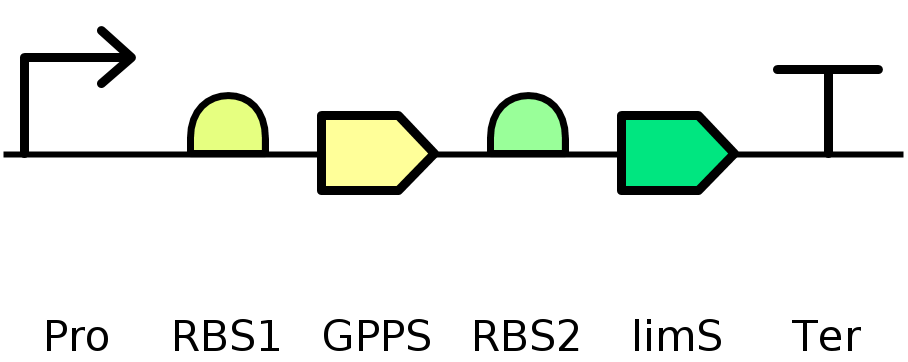

For each gene, we assumen that there are $n$ RBS motifs available. This will create a library of $n \times n$ possible combinations. In order to develop a machine-learning based predictive model, we will consider two approaches:

1. **Library characterisation**. In this approach the strength of each individual RBS is initially quantified by regulating the expression of some reporter gene or either is estimated using some mechanistic model like the ones used by the [RBS calculator](https://doi.org/10.1016/b978-0-12-385120-8.00002-4).

2. **Sequence encoding**. Since the RBS strengths are not always available and, more importantly, they are often context-dependent, the values calculated by the previous approach will not always work correctly for the genetic circuit. A second approach is based on using directly the sequence of the ribosome binding site to train a predictive model.

## 1. Modeling the limonene production circuit.

In order to start with this example, we need to be able to generate synthetic data simulating the response of the limonene bioproduction circuit under different RBS values. We assume here that the model is unknown or at least our knowledge about the mechanistic respose is not complete. That is the reason why we want to use machine learning approaches, as we want to replace the mechanistic model by some predictive algorithm that will be trained with the experimental data.

The actual model that will be used in the example is a set of ordinary differential equations (ODEs) based on transcription and translation dynamics and Michaelis-Menten enzyme kinetics, where some nonlinear terms have been added to account for the uncertainties and context dependencies. The details are in another notebook, but we do not need to look now into the details, simply import the function `limonene_production_dynamics` from the other notebook.

In [20]:
from Functions import limonene_production_dynamics

We can test now the simulation by using the function `odeint` from the module `scipy`, assuming for instance and RBS strength of 1 for both sequences. The simulation is performed for the 6 state variables of the circuit, which account for the time-course evolution of the concentration of the different chemical species that are involved in the circuit. More precisely, we will get the simulation of the following concentrations `[gppsm, limsm, gpps, lims, gpp, lim]`:

1. `ggpsm` and `limsm` are the two concentrations of the RNA messenger for the two genes. They have typically a fast response and short life.
2. `gpps`and `lims` are the concentrations of the two enzymes, which typically can last several hours and are slower to grow.
3. `gpp`is the intermediate, and `lim`is, finally the concentration of limonene.


Then, let's plot the dynamic response for limonene. We will need therefore to focus only on the last colum of the `result` variable:

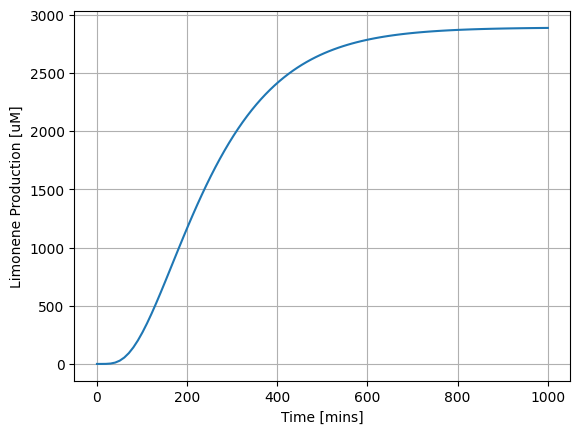

In [21]:
import matplotlib.pyplot as plt

time = np.linspace(0, 1000, 100)  # Time points for simulation

plt.plot(time, result[:, -1])
plt.xlabel('Time [mins]')
plt.ylabel('Limonene Production [uM]')
plt.grid()
plt.show()

Since the molecular weight of limonene is 136.23 g/mol, we see that approximately in 12 hours, there is an accumulation of around 4 mg/L. Such amount would not be probably industrially competitive, but it can be considered as a good starting point for optimization.

### 2 Library characterisation.

Assume now that we have $n=5$ RBS motifs for both RBS1 and RBS2, totalling 25 combinations. The strengh values will be in this example generated randomly:

In [22]:
import numpy as np

n = 5 # Number of RBS strengths to test
rbs1 = 10*np.random.rand(n)
rbs2 = 10*np.random.rand(n)
print(rbs1, rbs2)

[2.55781363 4.52531149 1.78010769 8.82427597 0.08348575] [8.68946027 2.13261758 2.03170028 4.07585538 3.32948017]


We can now plot the limonene production simulations for the 25-construct library.

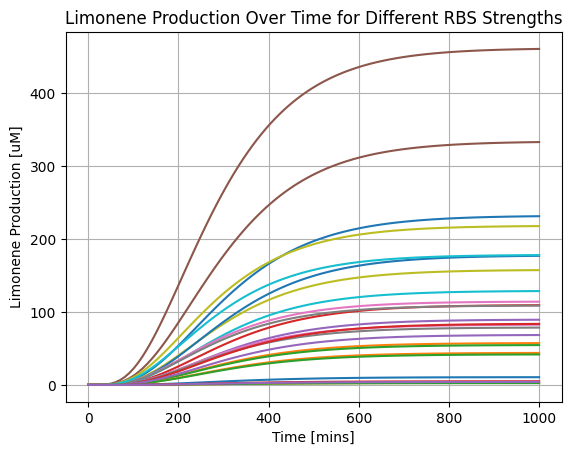

In [23]:
y0 = [0, 0, 0, 0, 0, 0]  # Initial conditions for the system
time = np.linspace(0, 1000, 100)  # Time points for simulation

X_ini = [] # Placeholder for RBS strengths combinations
Y_ini = [] # Placeholder for results

for rbs1_strength in rbs1:   # Example RBS strengths for gene 1
    for rbs2_strength in rbs2:   # Example RBS strengths for gene 2
        result = odeint(limonene_production_dynamics, y0, time, args=(rbs1_strength, rbs2_strength))
        X_ini.append([rbs1_strength, rbs2_strength])  # Store the RBS strengths
        yval = result[-1, -1]
        Y_ini.append(yval)  # Store the final limonene production value
        plt.plot(time, result[:, -1], label=f'RBS1: {rbs1_strength}, RBS2: {rbs2_strength}')


plt.xlabel('Time [mins]')
plt.ylabel('Limonene Production [uM]')
plt.title('Limonene Production Over Time for Different RBS Strengths')
plt.grid()
plt.show()


Our goal is to be able to use machine learning to predict the limonene titer based on the RBS strengths. We will compare two methods, the first one will be a linear regression and the second one will be based on Gaussian processes. We should expect that Gaussian processes will perform better than linear regression, as they have the ability of fitting nonlinear responses.

The input training data `X` are the RBS strenghts. Typically, the data will be scaled using `StandardScaler`in order to facilitate the convergence of the training algorithm. Here, we will perform a simple test where the training data will be randomly split into training and test sets. Once the model is trained, it will be evaluated against the test set. The evaluation metrics that will be use will be the mean squared error and the r2 score. Mean squared error should be as low as possible, whereas r2 score should be close to 1 as much as possible.

Try to run it several times and see what are the results.

In [24]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
scaler.fit(X_ini)
X = scaler.transform(X_ini)

# Convert Y to numpy array if it's a list
Y = np.array(Y_ini)


# Reshape Y if needed
Y = Y.reshape(-1)

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_pred_lin = lin_reg.predict(X_test)
print("Linear Regression MSE:", mean_squared_error(Y_test, Y_pred_lin))
print("Linear Regression R2:", r2_score(Y_test, Y_pred_lin))


# Gaussian Process Regression
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9, alpha=1e-2)
gaussian_process.fit(X_train, Y_train)
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)
print("Gaussian Process MSE:", mean_squared_error(Y_test, mean_prediction))
print("Gaussian Process R2:", r2_score(Y_test, mean_prediction))

Linear Regression MSE: 1156.093053462017
Linear Regression R2: 0.7581147265873626
Gaussian Process MSE: 2.599430417076948
Gaussian Process R2: 0.99945613033893


/Users/pablo/opt/anaconda3/envs/biosai/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/pablo/opt/anaconda3/envs/biosai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


What you will see is that the Gaussian Process model always perform significantly better than the linear regressor. The r2 score might vary from one run to another, but the mean squared error is clearly lower in all cases for Gaussian Processes.

### 3. Sequence encoding

As we have seen, knowing the RBS strengths and using a powerful method such as Gaussian Processes can help to develop a predictive system. However, most often the actual RBS strengths are unknown and other strategy is needed. Ultimately, the response could be predicted directly from the RBS sequence. However, using a mechanistic model is not always the best solution as there are several context dependencies that should be also considered.

Here, we will show an approach based on the encoding of sequences using the one-hot encoding strategy. First, we need to define the allowed nucleotides at each position of both RBS. In the following code, we calculate all possible combinatios for each RBS and for the combined set for the two genes:

In [25]:
from itertools import product
# Define allowed nucleotides for each position in the RBS sequences

allowed = {'R': ['A','G'], 'V': ['A','C','G'], 'S': ['C','G']}
variants1 = 'RRVS'
variants2 = 'RSVV'
variants = variants1 + variants2
possible = []
possible1 = []
possible2 = []
for i in range(len(variants)):
    possible.append(allowed[variants[i]])
for i in range(len(variants1)):
    possible1.append(allowed[variants1[i]])
for i in range(len(variants2)):
    possible2.append(allowed[variants2[i]])

combinations = list(product(*possible))
combinations1 = list(product(*possible1))
combinations2 = list(product(*possible2))

The next step is to define a function that depends on the sequence. As previously with the dynamic response model for limonene, we assume that this function is unknown and the goal is to estimate it using machine learning techniques.

In [26]:
from Functions import get_rbs_from_sequence

rbss1, rbss2 = get_rbs_from_sequence(combinations, combinations1, combinations2)

print("RBS strengths for each combination:")
for comb, strength in rbss1.items():
    print(f"{comb}: {strength}")

RBS strengths for each combination:
('A', 'A', 'A', 'C'): 25.91012454815938
('A', 'A', 'A', 'G'): 27.52065375528664
('A', 'A', 'C', 'C'): 22.299881086164206
('A', 'A', 'C', 'G'): 23.910410293291466
('A', 'A', 'G', 'C'): 23.910410293291466
('A', 'A', 'G', 'G'): 25.520939500418727
('A', 'G', 'A', 'C'): 23.910410293291466
('A', 'G', 'A', 'G'): 25.520939500418727
('A', 'G', 'C', 'C'): 20.30016683129629
('A', 'G', 'C', 'G'): 21.910696038423552
('A', 'G', 'G', 'C'): 21.910696038423552
('A', 'G', 'G', 'G'): 23.521225245550813
('G', 'A', 'A', 'C'): 23.910410293291466
('G', 'A', 'A', 'G'): 25.520939500418727
('G', 'A', 'C', 'C'): 20.30016683129629
('G', 'A', 'C', 'G'): 21.910696038423552
('G', 'A', 'G', 'C'): 21.910696038423552
('G', 'A', 'G', 'G'): 23.521225245550813
('G', 'G', 'A', 'C'): 21.910696038423552
('G', 'G', 'A', 'G'): 23.521225245550813
('G', 'G', 'C', 'C'): 18.300452576428377
('G', 'G', 'C', 'G'): 19.910981783555638
('G', 'G', 'G', 'C'): 19.910981783555638
('G', 'G', 'G', 'G'): 21.

We now again build a combinatorial library, in this case picking randomly some of the sequences:

In [27]:
libsize = 16

l1 = list(rbss1.keys())
l2 = list(rbss2.keys())

rkeys1 = np.random.choice(np.arange(len(l1)), libsize, replace=False) # pick random indices
rkeys2 = np.random.choice(np.arange(len(l2)), libsize, replace=False) # pick random indices

lib1 = [l1[i] for i in rkeys1]
lib2 = [l2[i] for i in rkeys2]

We repeat again the synthetic data generation, but this time the selection is based on sequences:

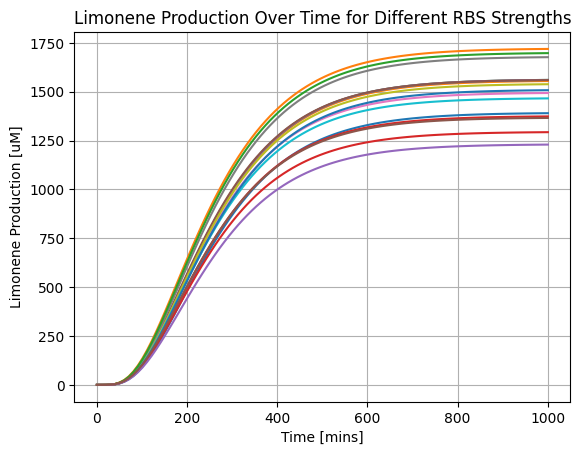

In [28]:
y0 = [0, 0, 0, 0, 0, 0]  # Initial conditions for the system
time = np.linspace(0, 1000, 100)  # Time points for simulation

X = [] # Placeholder for RBS strengths combinations
Y = [] # Placeholder for results

mylib = []

for i in np.arange(libsize): #[0.1, 0.5, 1.0]:  # Example RBS strengths for gene 1
        r1 = lib1[i] # select library one
        r2 = lib2[i] # select library two
        rbs1_strength = rbss1[r1] # RBS strength for first gene
        rbs2_strength = rbss2[r2] # RBS strength for second gene
        mylib.append((r1,r2))
        result = odeint(limonene_production_dynamics, y0, time, args=(rbs1_strength, rbs2_strength))
        X.append([rbs1_strength, rbs2_strength])  # Store the RBS strengths
        yval = result[-1, -1]
        #yval = np.sin((result[-1, -1] - 200000)/2000)+np.random.normal()
        #yval = np.sin(rbs1_strength)+ np.sin(rbs2_strength)
        Y.append(yval+0*np.random.normal())  # Store the final limonene production value
        plt.plot(time, result[:, -1], label=f'RBS1: {rbs1_strength}, RBS2: {rbs2_strength}')


plt.xlabel('Time [mins]')
plt.ylabel('Limonene Production [uM]')
plt.title('Limonene Production Over Time for Different RBS Strengths')
plt.grid()
plt.show()


We next will build the training set based on the one-hot encoding of the sequences:

In [29]:
from Functions import one_hot_encoding

Xd = one_hot_encoding(mylib)
print(Xd)

[[0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0]
 [0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0]
 [0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1]
 [0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1]
 [0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1]
 [1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0]
 [1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1]
 [0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1]
 [1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0]
 [1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0]
 [1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0]
 [0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0]
 [0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1]]


We use now this input to train the predictive model, as we did before with the RBS strengths.

Linear Regression MSE: 3013.637926475225
Linear Regression R2: 0.8534682296334428
Gaussian Process MSE: 6844.320749900014
Gaussian Process R2: 0.6672093791929332


/Users/pablo/opt/anaconda3/envs/biosai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


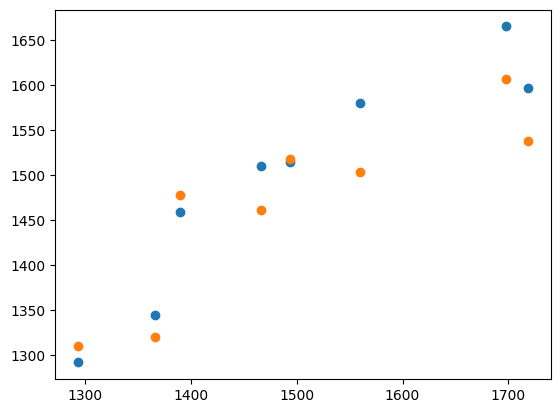

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Xd0 = Xd
scaler = StandardScaler()
scaler.fit(Xd)
Xd = scaler.transform(Xd)

# Convert Y to numpy array if it's a list
Y = np.array(Y)

# Reshape Y if needed
Y = Y.reshape(-1)

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(Xd, Y, test_size=0.5)

# Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
X_test1 = X_test
Y_test1 = Y_test
Y_pred_lin = lin_reg.predict(X_test1)
print("Linear Regression MSE:", mean_squared_error(Y_test1, Y_pred_lin))
print("Linear Regression R2:", r2_score(Y_test1, Y_pred_lin))


kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,alpha=1e-2)
gaussian_process.fit(X_train, Y_train)
mean_prediction, std_prediction = gaussian_process.predict(X_test1, return_std=True)
print("Gaussian Process MSE:", mean_squared_error(Y_test1, mean_prediction))
print("Gaussian Process R2:", r2_score(Y_test1, mean_prediction))

plt.scatter(Y_test1, Y_pred_lin)
plt.scatter(Y_test1, mean_prediction)
plt.show()

### 4. Neural networks and deep learning

As the number of samples and input features grow in scale, it becomes apparent that a more powerful learning algorithm is needed. Deep learning algorithms, based on neural networks, can help to deal with multidimensional and large-scale problems. In our example, we have kept the number of training samples low, but there is the possibility of addressing a larger problem through the use of neural networks.

Here, we will show you how this problem can be tackled by generating a larger training data. We come back to our previous example, but now the design space will be significantly larger:

In [31]:
from itertools import product
# Define allowed nucleotides for each position in the RBS sequences

allowed = {'R': ['A','G'], 'V': ['A','C','G'], 'S': ['C','G']}
variants1 = 'RRVSRRS'
variants2 = 'RSVVRVV'
variants = variants1 + variants2
possible = []
possible1 = []
possible2 = []
for i in range(len(variants)):
    possible.append(allowed[variants[i]])
for i in range(len(variants1)):
    possible1.append(allowed[variants1[i]])
for i in range(len(variants2)):
    possible2.append(allowed[variants2[i]])

combinations = list(product(*possible))
combinations1 = list(product(*possible1))
combinations2 = list(product(*possible2))
len(combinations)

124416

In [32]:
from Functions import get_rbs_from_sequence

rbss1, rbss2 = get_rbs_from_sequence(combinations, combinations1, combinations2)

libsize = 150

l1 = list(rbss1.keys())
l2 = list(rbss2.keys())

rkeys1 = np.random.choice(np.arange(len(l1)), libsize, replace=False) # pick random indices
rkeys2 = np.random.choice(np.arange(len(l2)), libsize, replace=False) # pick random indices

lib1 = [l1[i] for i in rkeys1]
lib2 = [l2[i] for i in rkeys2]

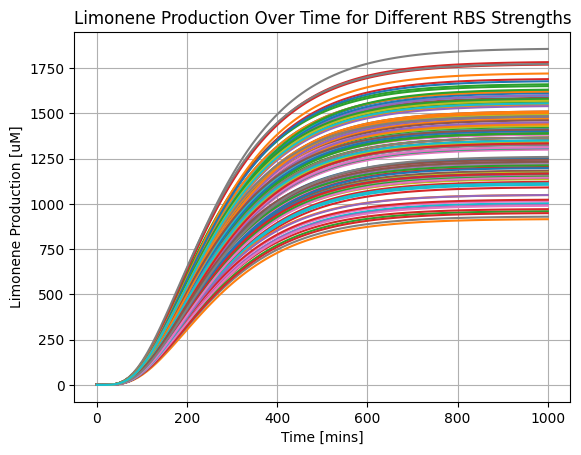

In [33]:
y0 = [0, 0, 0, 0, 0, 0]  # Initial conditions for the system
time = np.linspace(0, 1000, 100)  # Time points for simulation

X = [] # Placeholder for RBS strengths combinations
Y = [] # Placeholder for results

mylib = []

for i in np.arange(libsize): #[0.1, 0.5, 1.0]:  # Example RBS strengths for gene 1
        r1 = lib1[i] # select library one
        r2 = lib2[i] # select library two
        rbs1_strength = rbss1[r1] # RBS strength for first gene
        rbs2_strength = rbss2[r2] # RBS strength for second gene
        mylib.append((r1,r2))
        result = odeint(limonene_production_dynamics, y0, time, args=(rbs1_strength, rbs2_strength))
        X.append([rbs1_strength, rbs2_strength])  # Store the RBS strengths
        yval = result[-1, -1]
        #yval = np.sin((result[-1, -1] - 200000)/2000)+np.random.normal()
        #yval = np.sin(rbs1_strength)+ np.sin(rbs2_strength)
        Y.append(yval+0*np.random.normal())  # Store the final limonene production value
        plt.plot(time, result[:, -1], label=f'RBS1: {rbs1_strength}, RBS2: {rbs2_strength}')


plt.xlabel('Time [mins]')
plt.ylabel('Limonene Production [uM]')
plt.title('Limonene Production Over Time for Different RBS Strengths')
plt.grid()
plt.show()

In [34]:
from Functions import one_hot_encoding

Xd = one_hot_encoding(mylib)
print(Xd)
Xd.shape

[[0 0 1 ... 0 1 0]
 [0 0 1 ... 0 1 0]
 [0 0 1 ... 0 1 0]
 ...
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]]


(150, 42)

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from Functions import one_hot_encoding

Xd0 = Xd
scaler = StandardScaler()
scaler.fit(Xd)
Xd = scaler.transform(Xd)

model = Sequential()
model.add(Dense(64, input_dim=Xd.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(Xd, np.array(Y), epochs=200, batch_size=16, verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 1ms/step - loss: 1865441.7500
Epoch 2/200
10/10 [==============================] - 0s 1ms/step - loss: 1863416.3750
Epoch 3/200
10/10 [==============================] - 0s 988us/step - loss: 1861175.6250
Epoch 4/200
10/10 [==============================] - 0s 953us/step - loss: 1858519.0000
Epoch 5/200
10/10 [==============================] - 0s 937us/step - loss: 1855048.5000
Epoch 6/200
10/10 [==============================] - 0s 811us/step - loss: 1850689.2500
Epoch 7/200
10/10 [==============================] - 0s 857us/step - loss: 1845279.1250
Epoch 8/200
10/10 [==============================] - 0s 982us/step - loss: 1838582.6250
Epoch 9/200
10/10 [==============================] - 0s 1ms/step - loss: 1830400.3750
Epoch 10/200
10/10 [==============================] - 0s 1ms/step - loss: 1820527.7500
Epoch 11/200
10/10 [==============================] - 0s 801us/step - loss: 1808782.8750
Epoch 12/200
10/10 [==================

5/5 [==============================] - 0s 733us/step


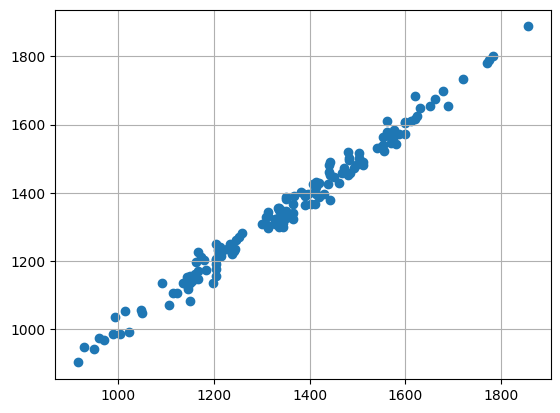

In [36]:

plt.scatter(Y, model.predict(Xd))
plt.grid()
plt.show()